In [ ]:
epochs, batch, lr = 100, 32, 1e-4
num_clients, in_channels, num_classes = 6, 1, 10
Dataset, Model, Prefix = 'MNIST', 'CNN_3', 'Attack'
Gdrive = '/content/drive/MyDrive/ColabNotebooks/SplitLearning3'
import torch; torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os; os.chdir(Gdrive)
%run library/Dataset.ipynb
%run library/Network.ipynb
%run library/Training.ipynb
from torchsummary import summary

In [ ]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, SSIM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00


In [ ]:
def reconstruct(decoders):
  image = next(iter(DataLoader(testset)))[0]
  plt.imshow(transforms.ToPILImage()(image[0]))
  plt.figure(figsize=(32,8))
  for i in range(num_clients):
    plt.subplot(1, num_clients, i+1)
    with torch.no_grad():
      network.clients[i].eval(), decoders[i].eval()
      output = decoders[i](network.clients[i](image.cuda()))
    plt.imshow(transforms.ToPILImage()(output.cpu()[0]))
    plt.title('{}, {:.0e}'.format(ssim(image, output.cpu(), 1.0), F.mse_loss(image, output.cpu())))

In [ ]:
def reconstruct2(decoders):
    similarities = [[] for i in range(num_clients)]
    for images, _ in tqdm(DataLoaderGPU(testset, batch * 2)):
        for i in range(num_clients):
            with torch.no_grad():
                network.clients[i].eval(), decoders[i].eval()
                output = decoders[i](network.clients[i](images))
            similarities[i].append(ssim(images, output, 1.0).item())
    for sim in similarities:
        print(np.mean(sim))

#Fashion

In [ ]:
dataset, testset = loadDataset('Fashion')

100%|██████████| 26421880/26421880 [00:03<00:00, 8591914.92it/s] 


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 169065.57it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3150666.03it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2796927.07it/s]


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [ ]:
clients = torch.ones((num_clients,))
clients = ratio_split(dataset, clients / clients.sum())

In [ ]:
class Decoder(Autodecoder):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose2d(32, 16, 3, 2, 1, 1), nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, 1, 1), nn.Sigmoid()
    )
  def forward(self, x):
    return self.model(x)

In [ ]:
class Adversary(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(32, 1, 3, 2, 1, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

#ResSFL

https://github.com/zlijingtao/ResSFL

In [ ]:
def train_network(self, epoch, alpha2):
    local = lambda m, p: m.client[0] if p else m
    self.server.train()
    models = (self.clients[-1].state_dict(), self.clients[-1].decoder.state_dict())
    for idx, client in enumerate(self.clients):
        client.load_state_dict(models[0]), client.decoder.load_state_dict(models[1])
        client.train(), client.decoder.train()
        for images, labels in client.loader:
            client.zero_grad(), self.server.zero_grad()
            client.decoder.zero_grad()

            z_private = client(images)
            output_image = client.decoder(z_private.detach())
            gan_loss = F.mse_loss(output_image, images)
            gan_loss.backward()
            client.decoder.optimizer.step()

            output = self.server(z_private)
            f_loss = F.cross_entropy(output, labels)
            client.decoder.eval()
            output_image = client.decoder(z_private)
            gan_loss = ssim(output_image, images, 1., False).abs().mean() * alpha2

            total_loss = f_loss + gan_loss
            total_loss.backward()
            client.backward(z_private.grad)
            client.optim_step()

            self.server.optim_step()
        client.sched_step(), client.decoder.scheduler.step()
        models = (client.state_dict(), client.decoder.state_dict())
    self.server.sched_step()

def train_splitnn(clients, testset, method, epochs=epochs, model=Model, alpha2=1):
    in_channels, num_classes, tester = loadTester(testset)
    models = [globals()[model](in_channels, num_classes) for c in clients]
    model = SplitNN([Client(m.client) for m in models], Server(models[0].server))
    model.initialize(clients, tester, epochs, batch, lr)
    for client in model.clients:
        client.decoder = Adversary().cuda()
        client.decoder.optimizer = optim.Adam(client.decoder.parameters(), lr)
        client.decoder.scheduler = optim.lr_scheduler.CosineAnnealingLR(client.decoder.optimizer, epochs)

    for epoch in tqdm(range(epochs)):
        train_network(model, epoch, alpha2)
        model.evaluate()
        plot_progress(model.clients, locals())
    return model

In [ ]:
class VGG_7_ResSFL(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)

In [ ]:
class VGG_7_ResSFL(VGG_7):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__(in_channels, num_classes, dropout)

network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 0)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

In [ ]:
class Decoder2(Autodecoder):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.LeakyReLU(.2),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU(.2),
            #nn.Conv2d(16, 16, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU(.2),
            nn.ConvTranspose2d(16, 1, 3, 1, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

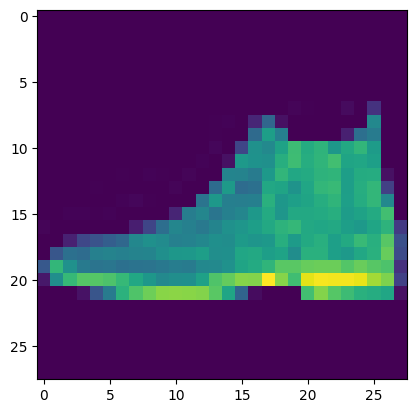

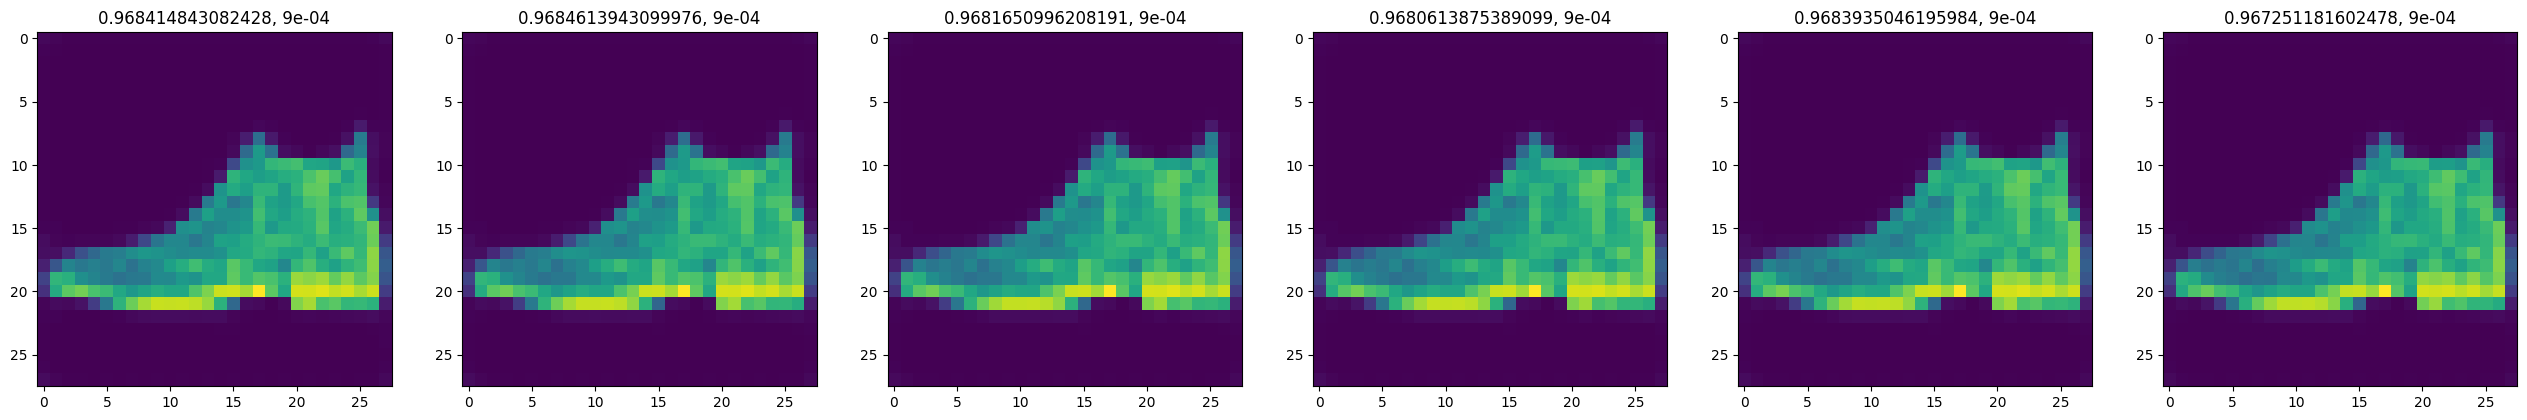

In [ ]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

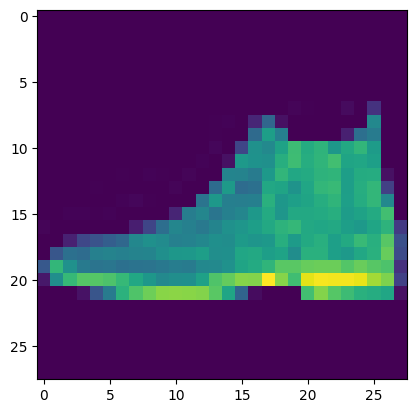

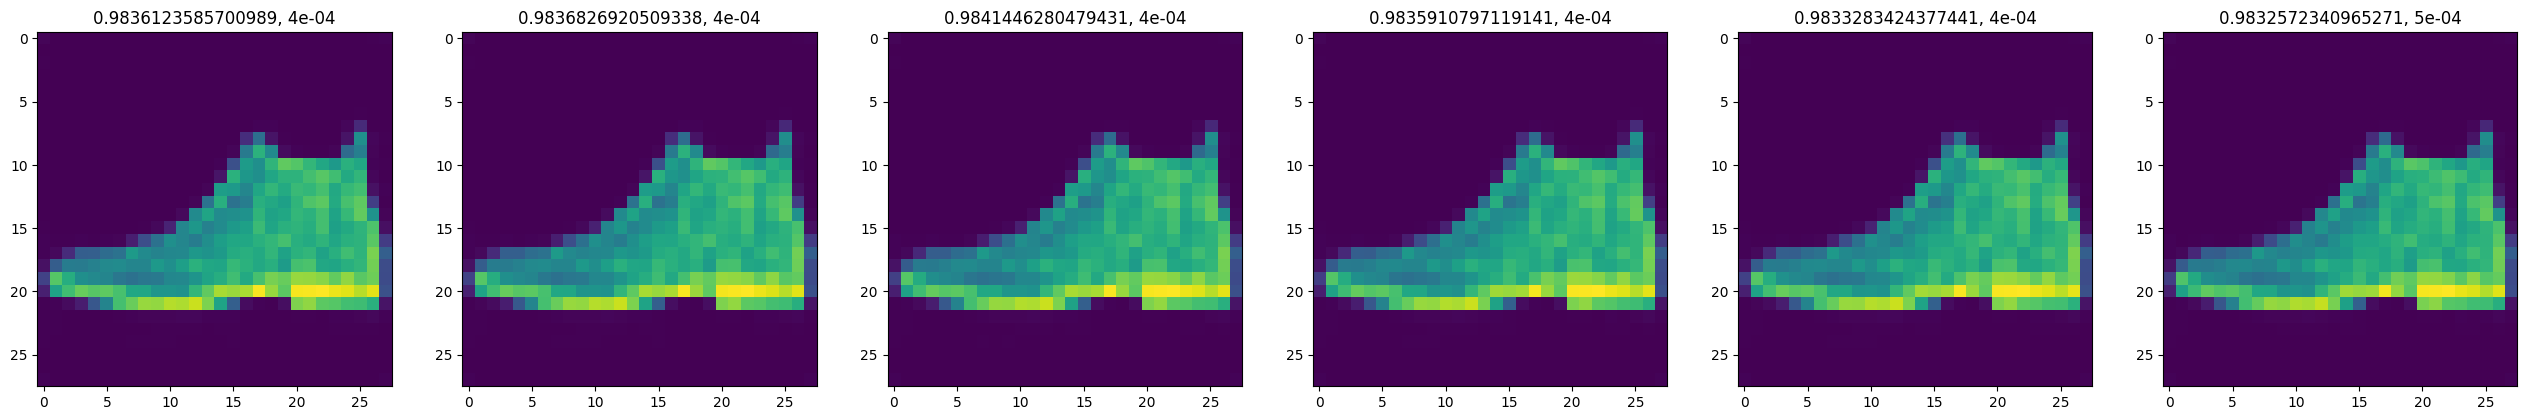

In [ ]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.5737798054506824
0.5751828650000749
0.5663539771061794
0.5716064746972103
0.5706068888591354
0.5683812704055932


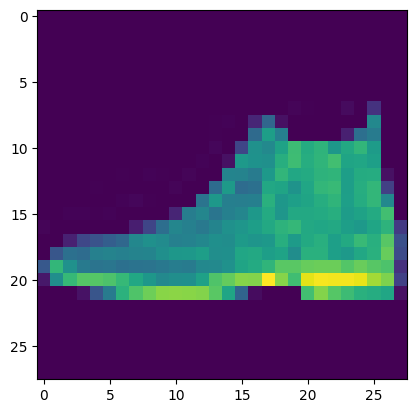

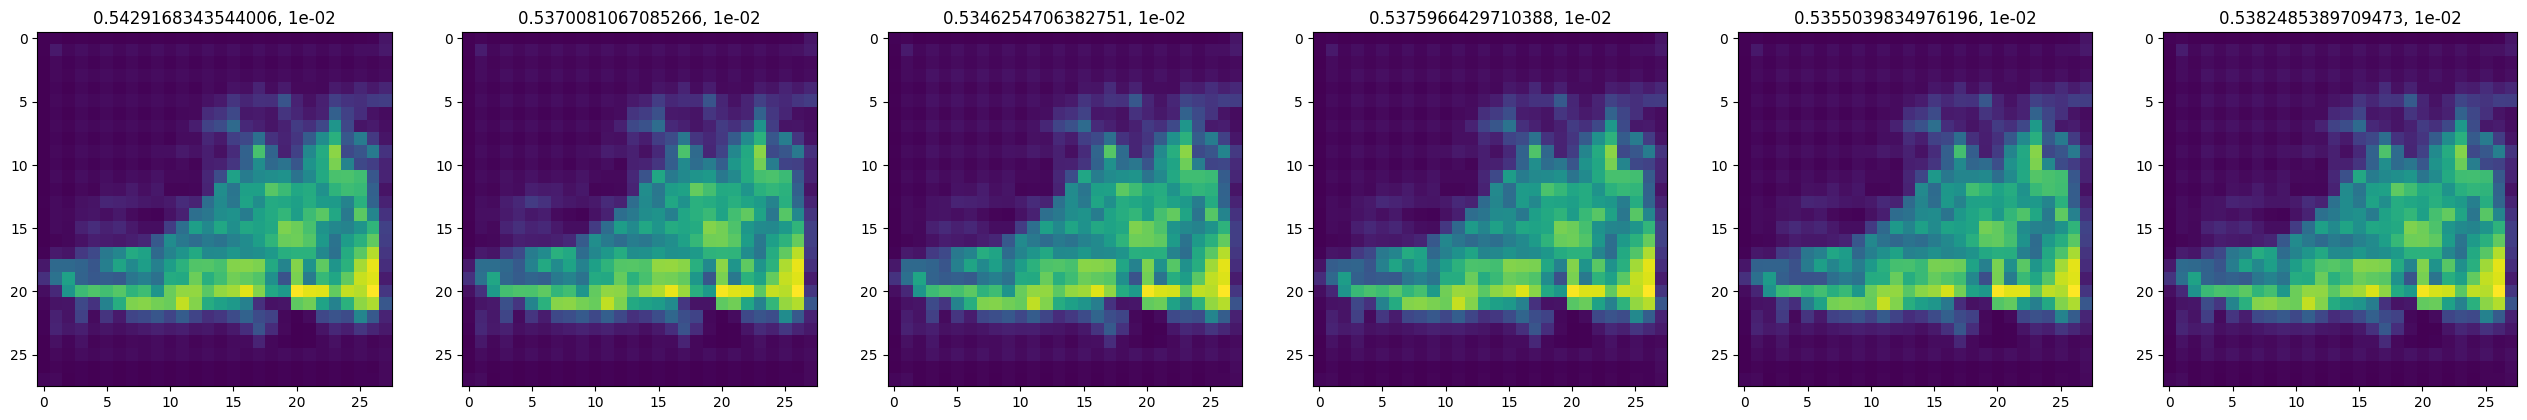

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 1)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.916898613143119
0.9172507748482334
0.9146213744096695
0.9164454094163931
0.9151308775707415
0.9155007278083995


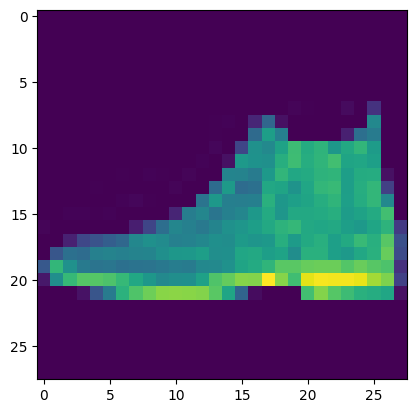

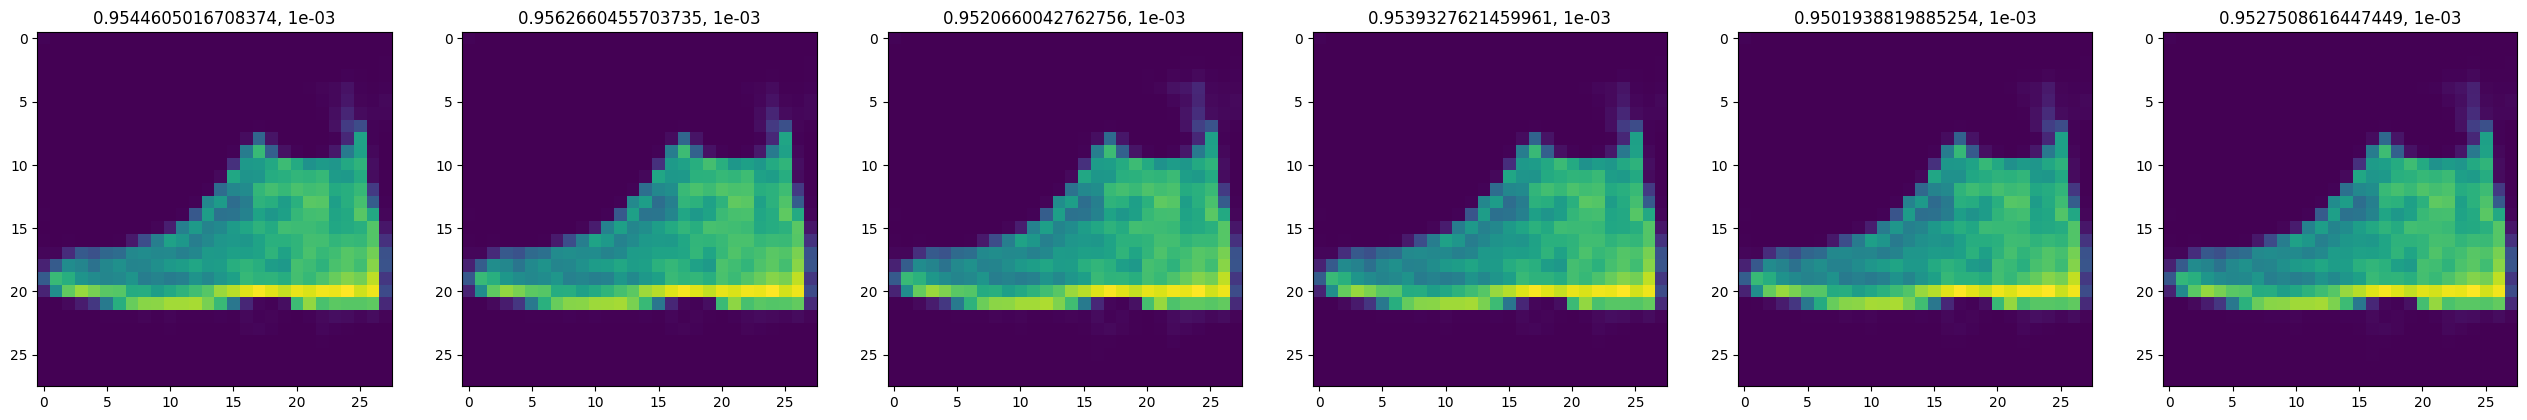

In [ ]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.9226914856843887
0.9221246079274803
0.9226883957340459
0.9225952473415691
0.9208096865635769
0.9224505538393737


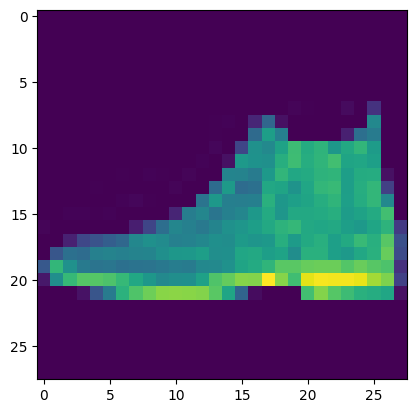

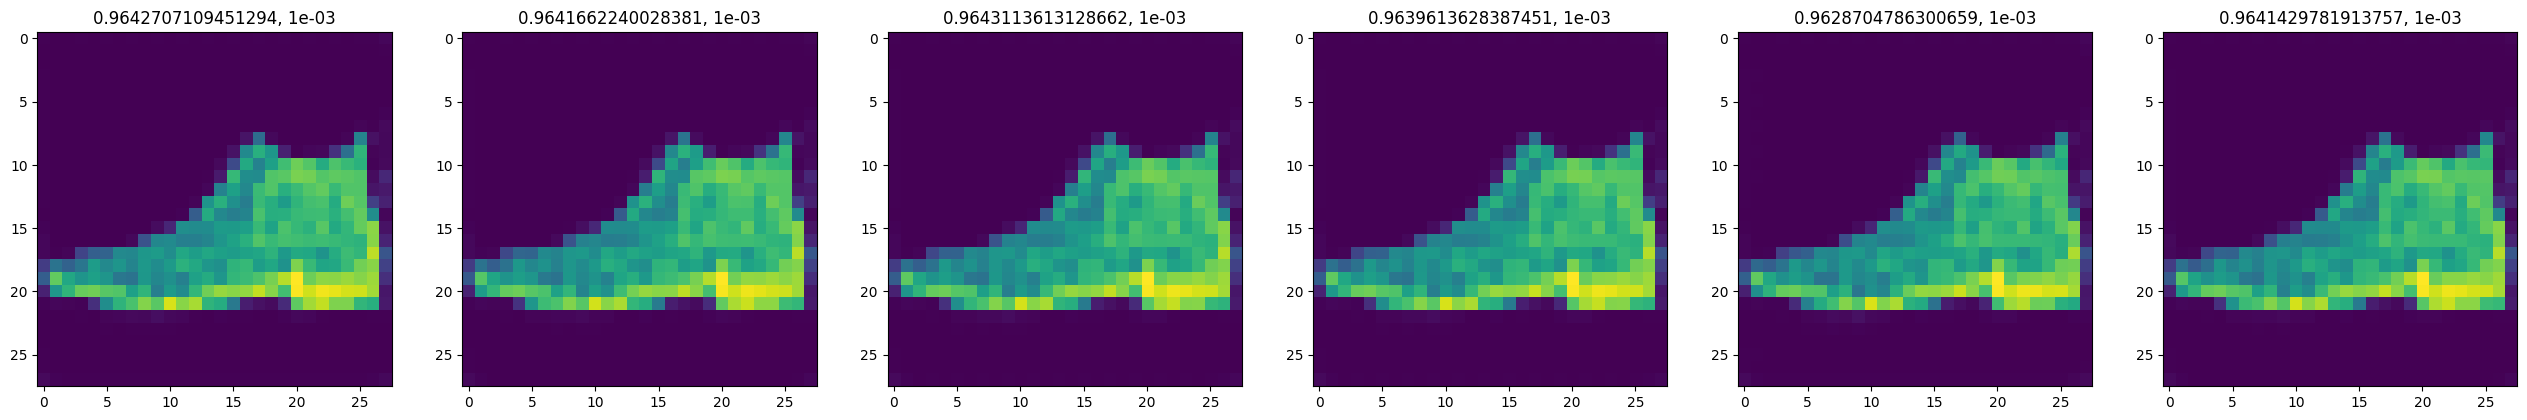

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 10)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.9548167924212801
0.9547130176975469
0.9550908473646564
0.9551366966241485
0.9525594863162679
0.9549560489927887


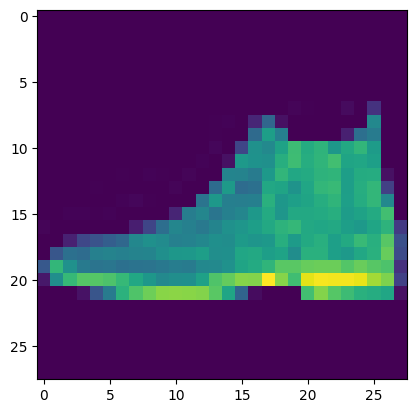

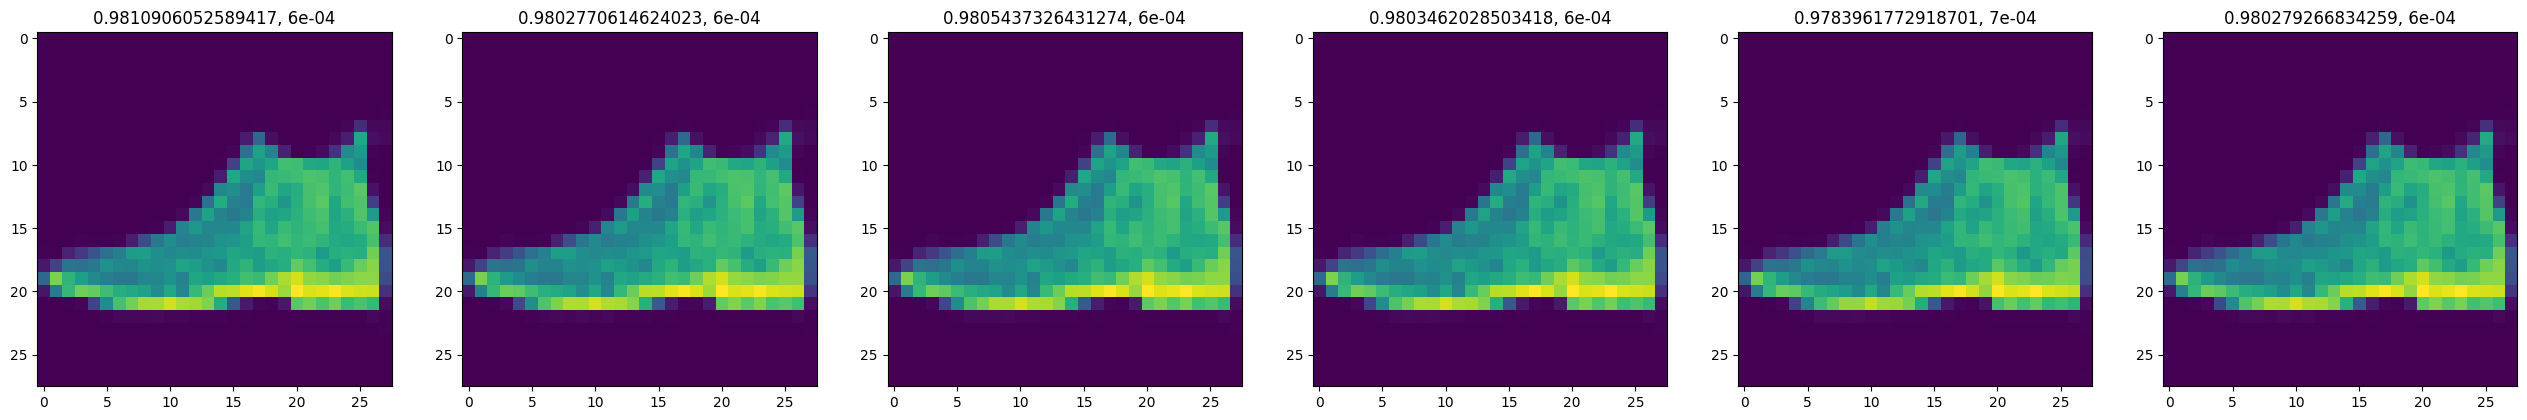

In [ ]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 100)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.8277135411645197
0.826825377288138
0.8259947952950836
0.8282217763032124
0.8286764648309939
0.8287118984635469


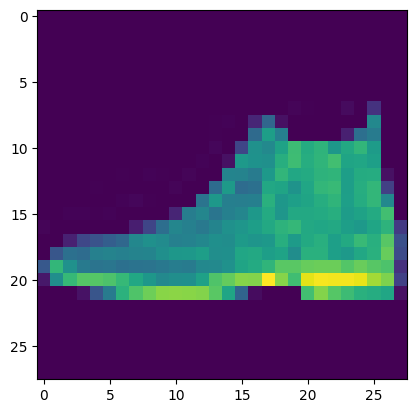

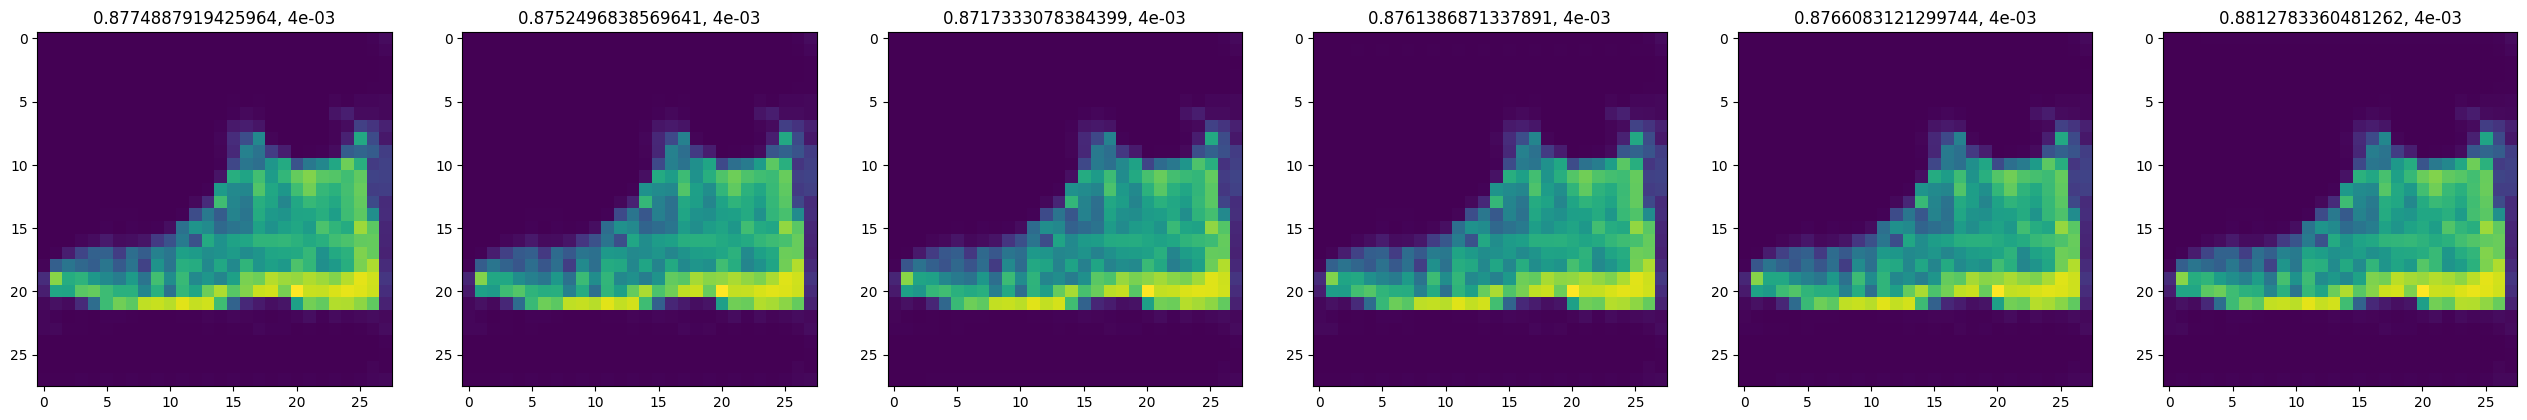

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 5)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.5370977270375391
0.5032388968452527
0.5248312147179987
0.5365190889425339
0.5232250396233455
0.5277881599535608


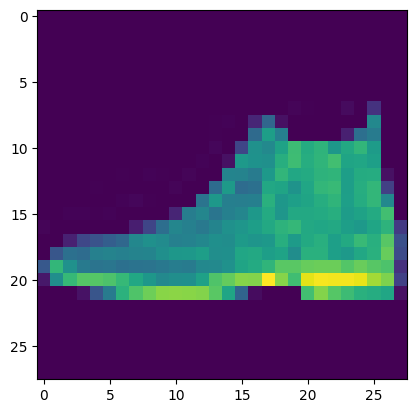

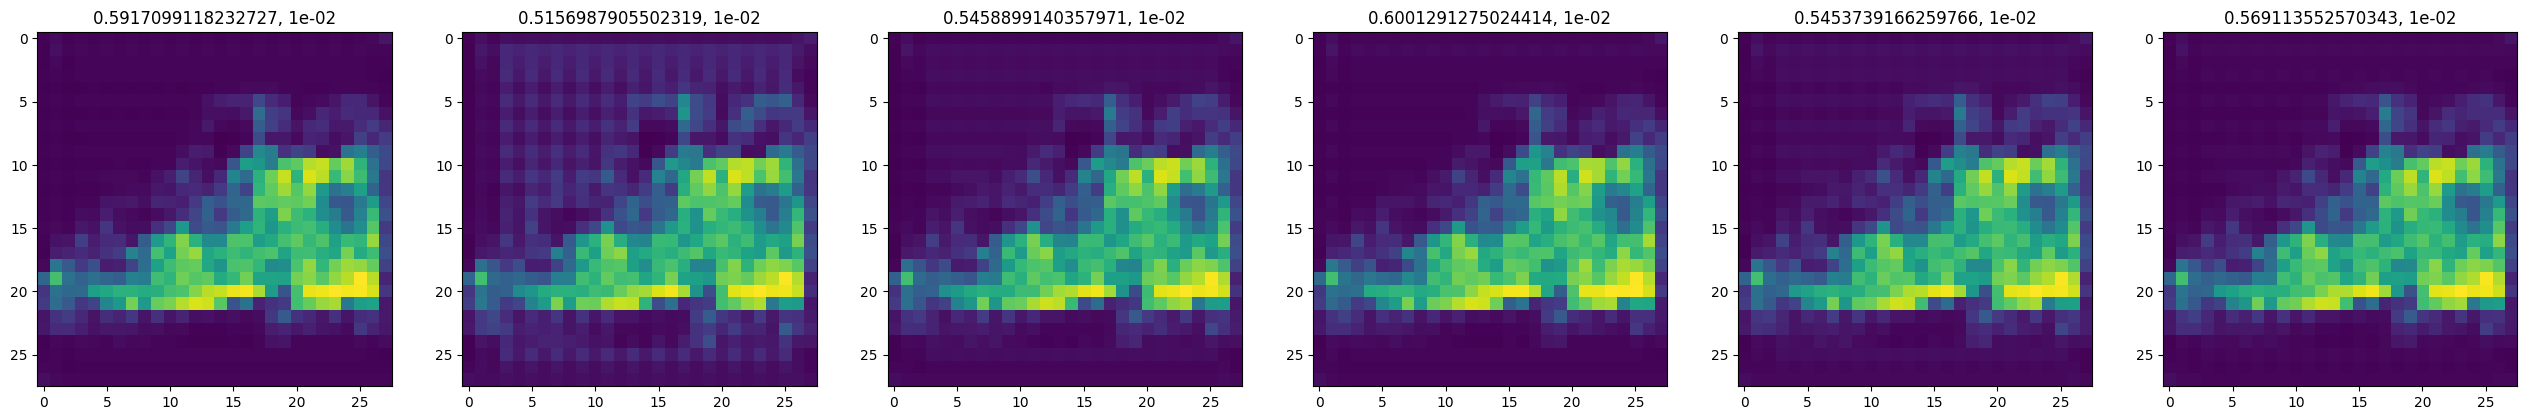

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', .5)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.8724672433676993
0.8678183578381873
0.8692829627899608
0.8675974330325036
0.8676418756983083
0.8704422382032795


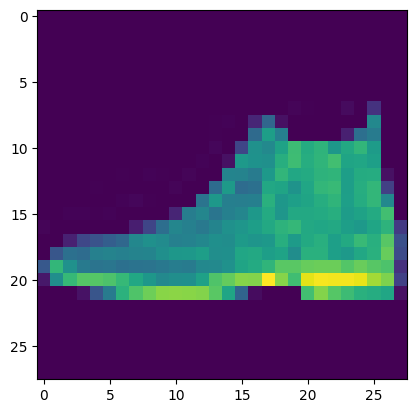

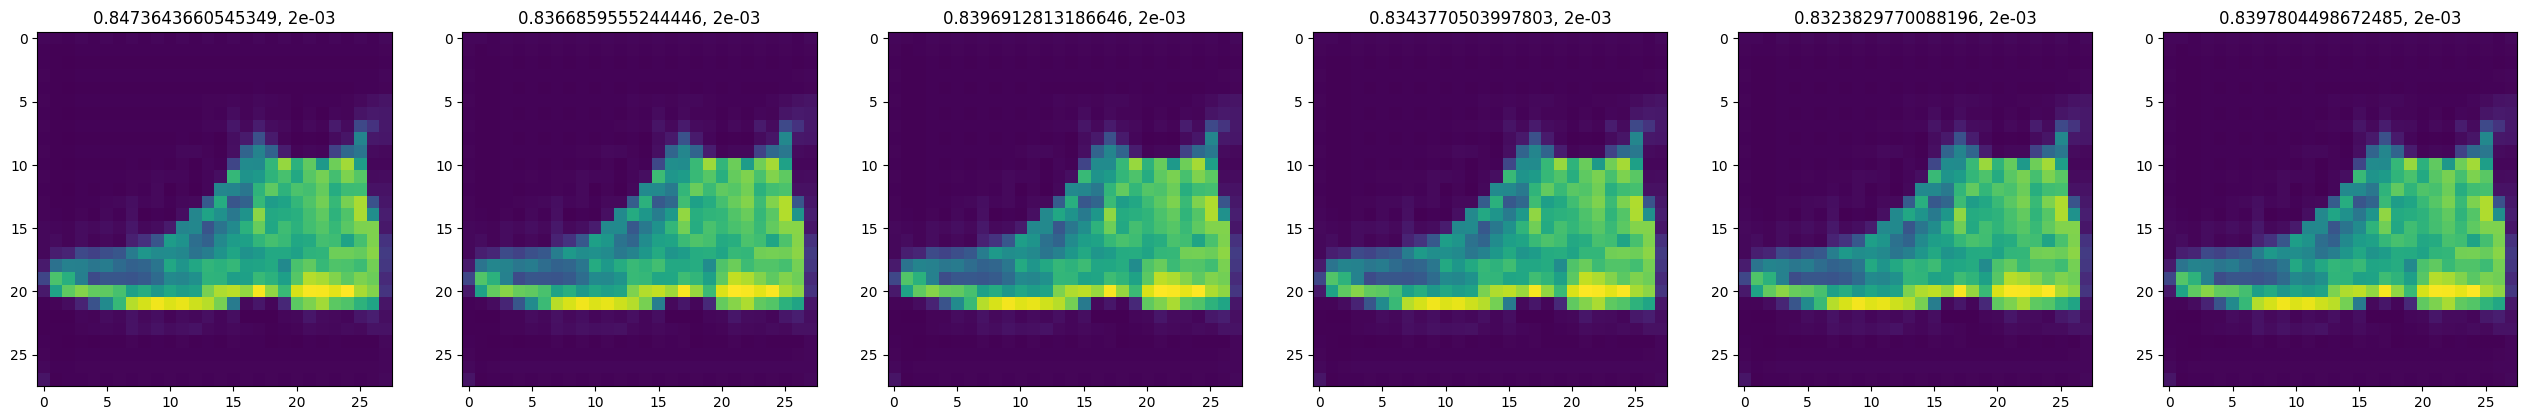

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', .5)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.9627970009093072
0.9613792615331662
0.9622994308259077
0.9618291266404899
0.962373381207703
0.9626583844233471


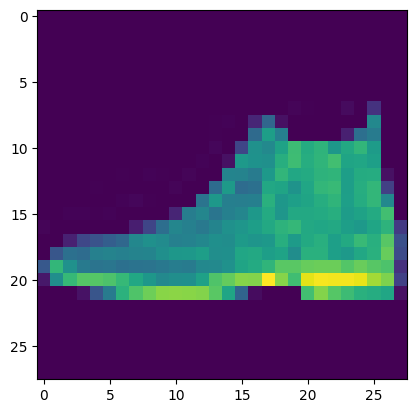

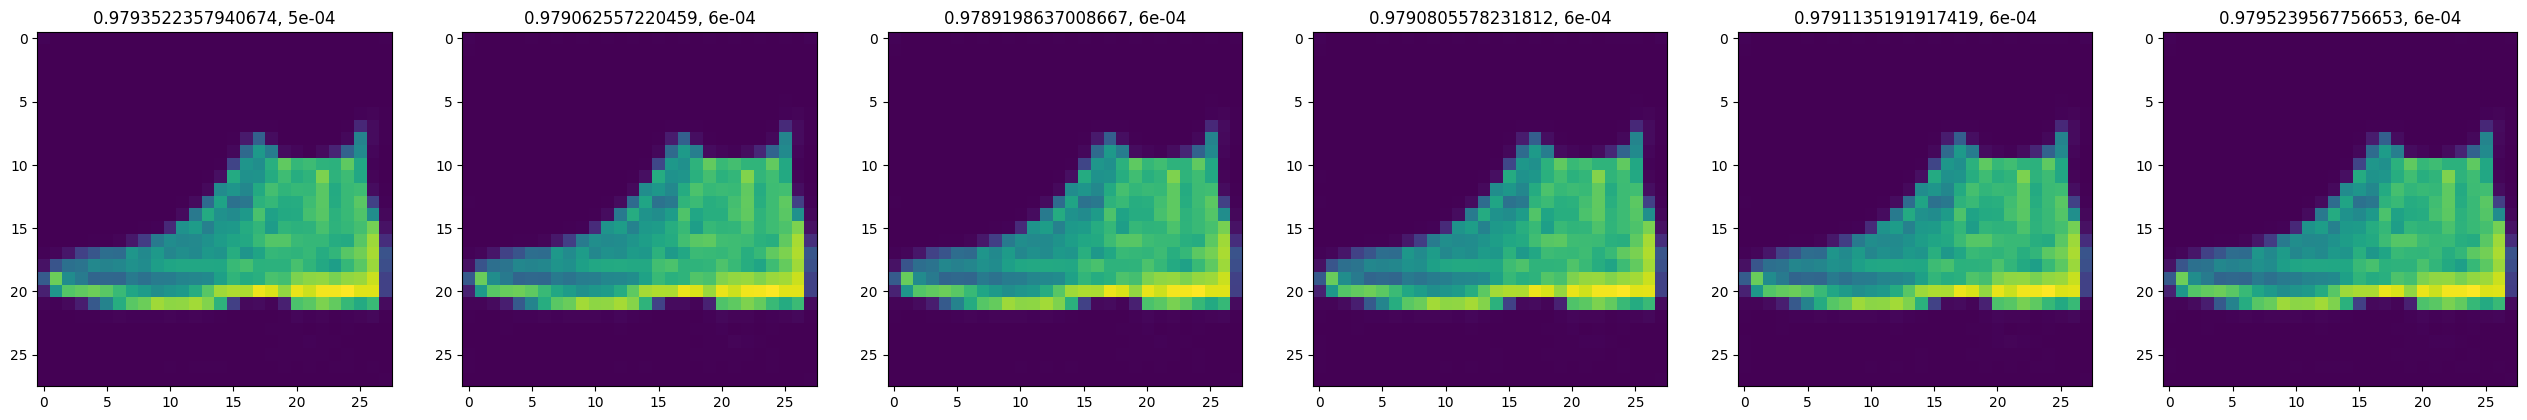

In [ ]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.8985260174532604
0.9027306763989151
0.9000500425411637
0.9004457418326359
0.9003929192093527
0.8995705429156116


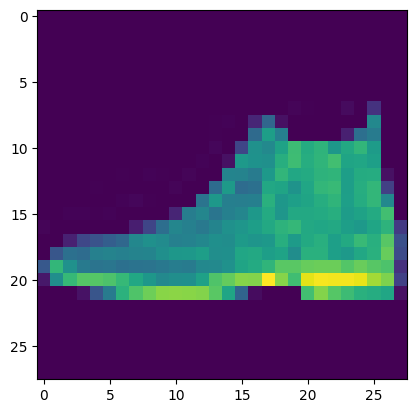

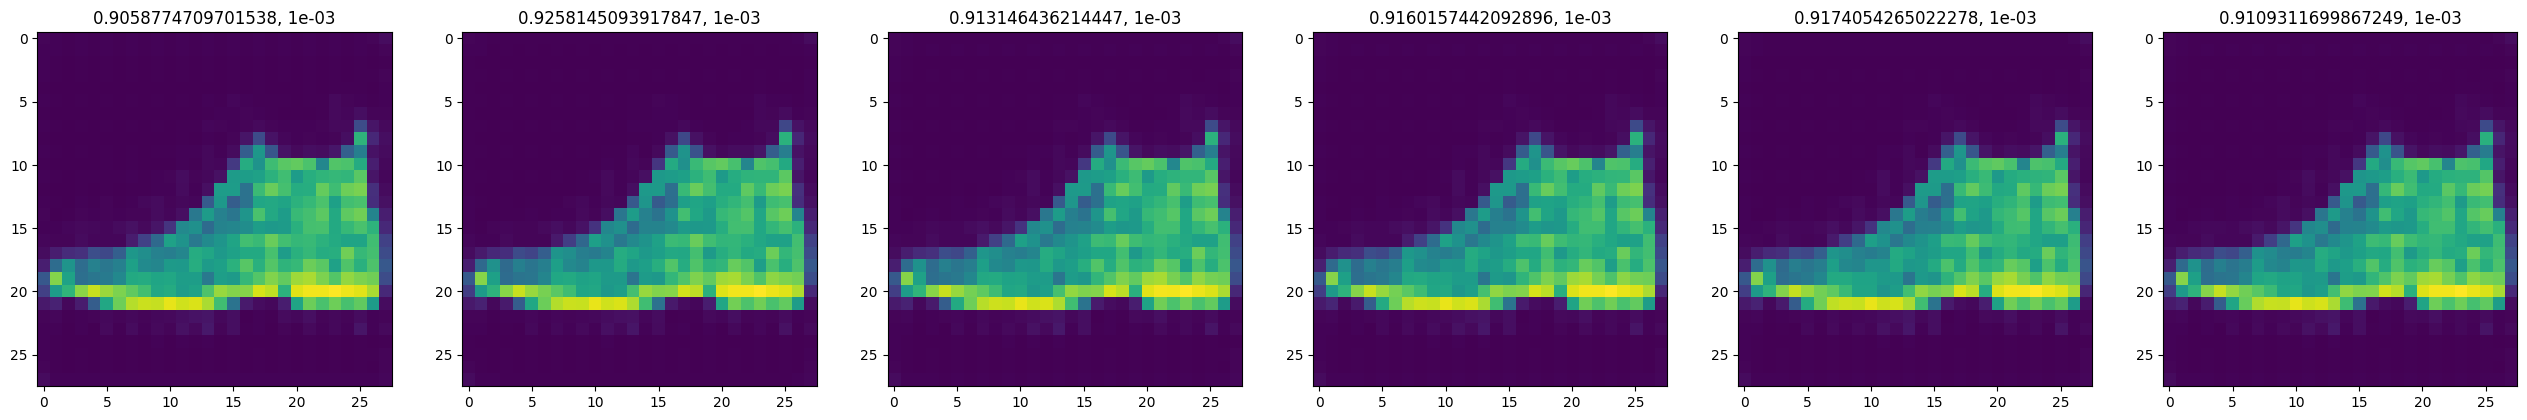

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 1)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.8594702216470318
0.8485329728217641
0.8488473839061276
0.8393629724812356
0.8573513923177294
0.8515396114367588


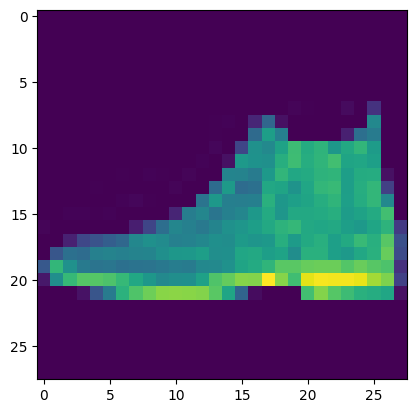

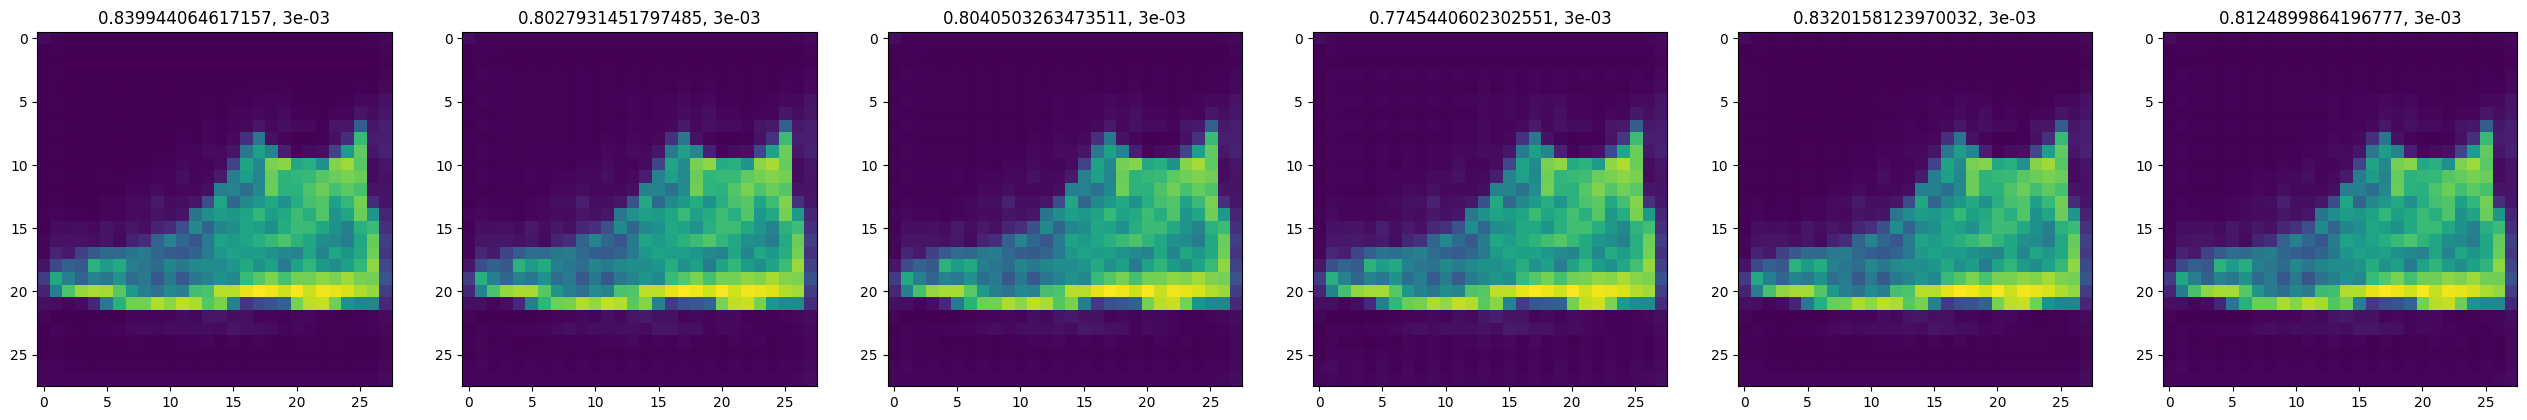

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 5)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.9231751470049475
0.9225993194397847
0.9227101081495832
0.9232472158541345
0.9224517770633576
0.9228591569669687


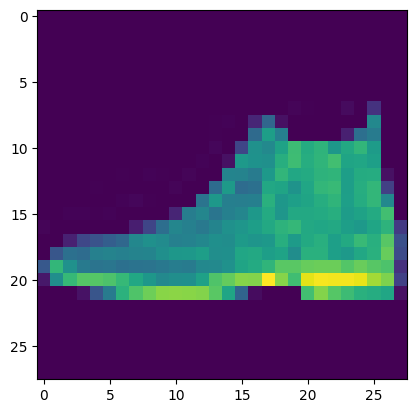

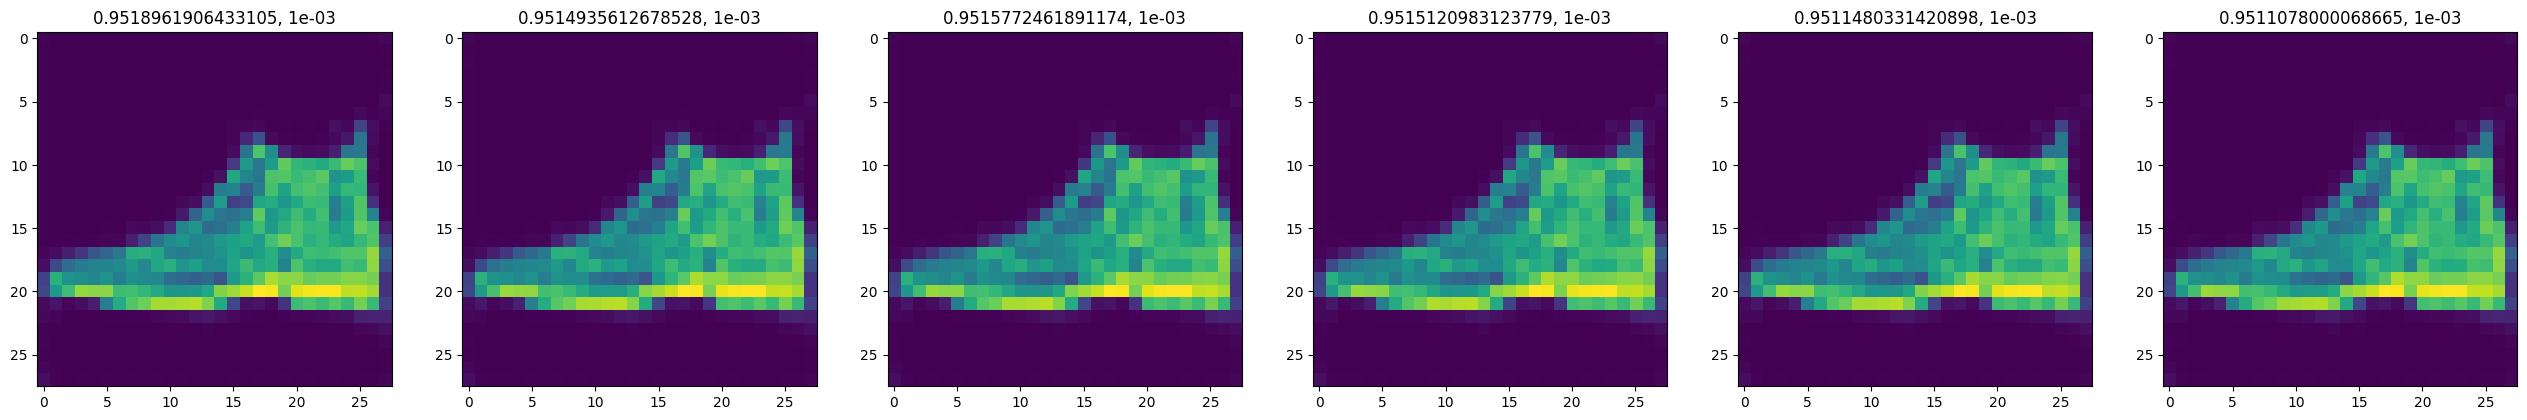

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 10)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.940691234959159
0.9397284183532569
0.9384074165562916
0.9405505820444435
0.9399942937929919
0.9396488837375763


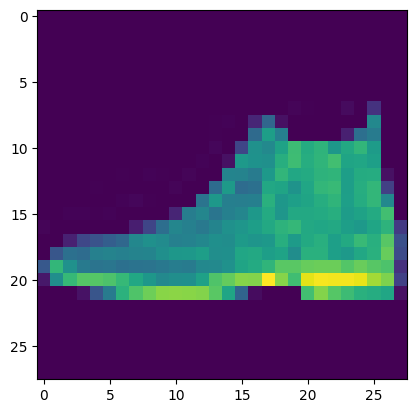

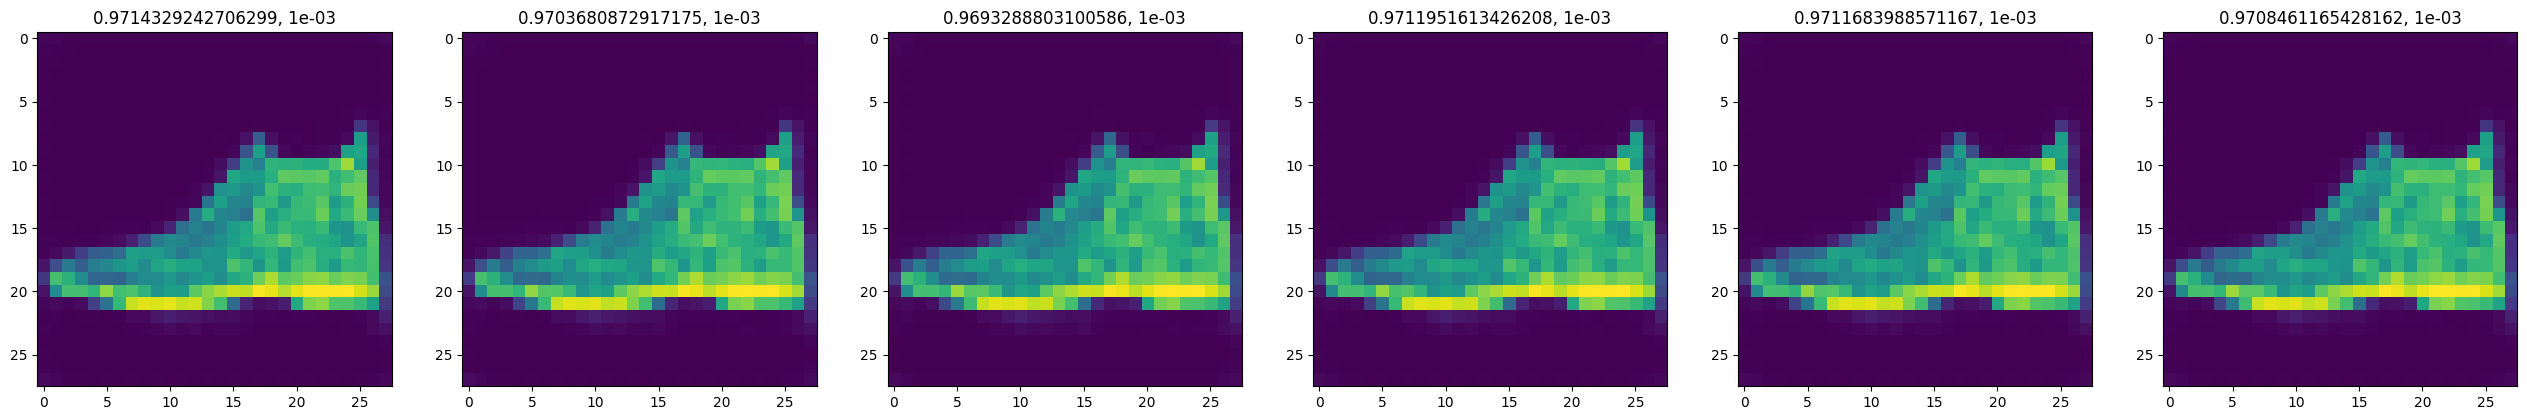

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 50)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.9253713689791928
0.9239949523263676
0.9214392858705703
0.9236697152162053
0.9220644531735949
0.9211836662262108


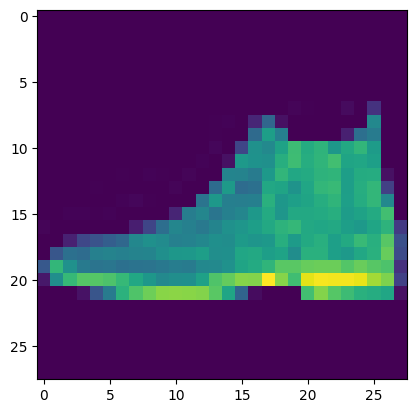

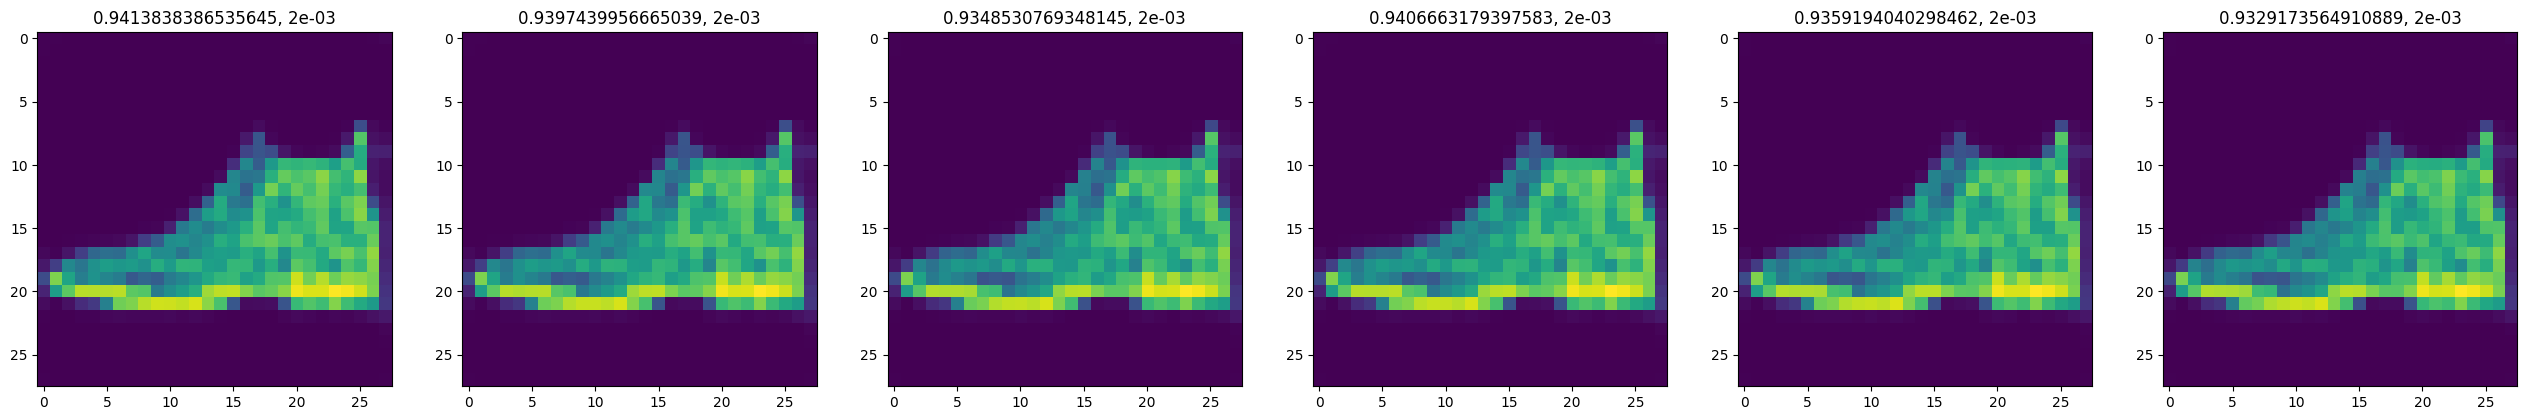

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 100)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.9135448093626909
0.9141827555978375
0.9139413810839319
0.9133395905707292
0.9133069310218666
0.913788214230993


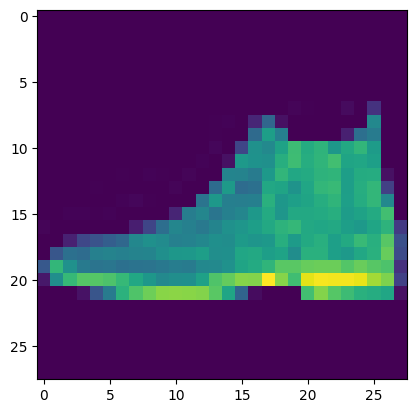

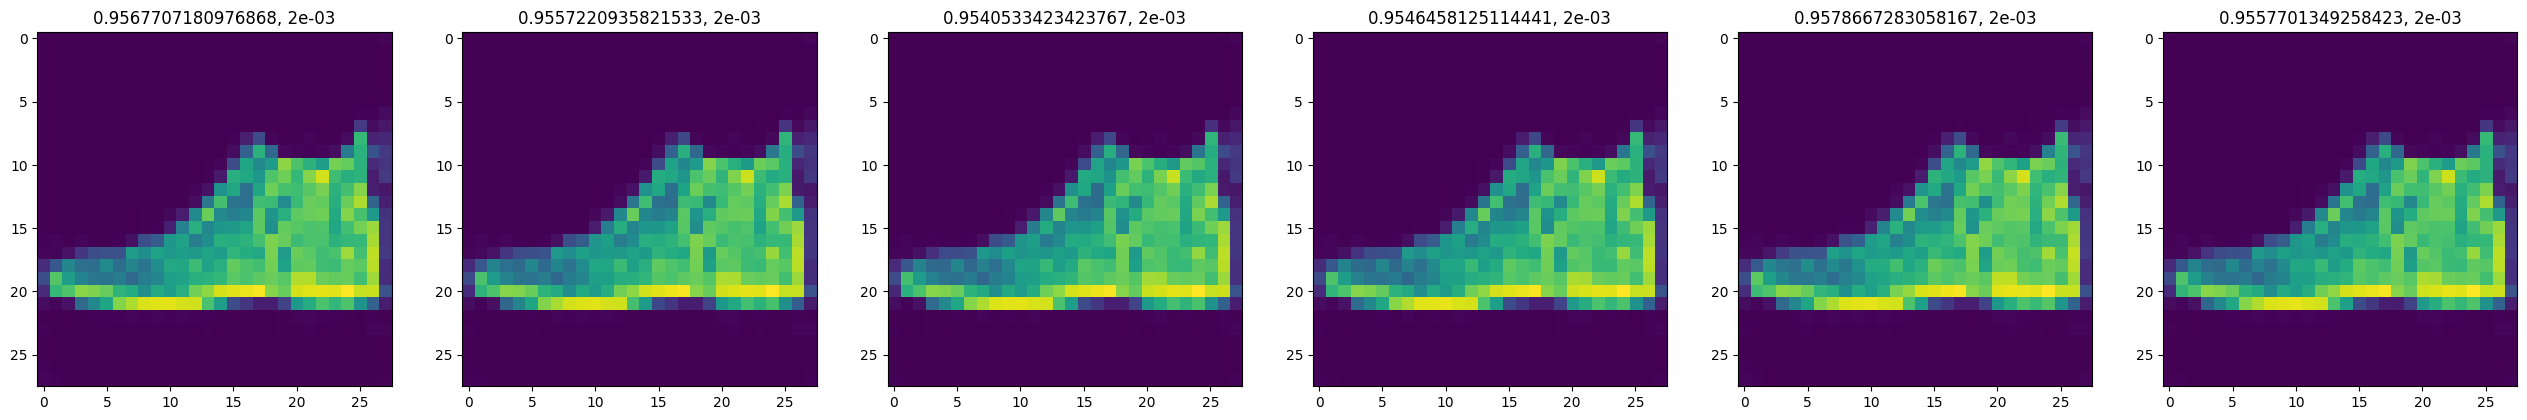

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 500)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.8673701404006617
0.8713359149398318
0.8681176433897322
0.8696679602003401
0.8673249323656604
0.8693163683460017


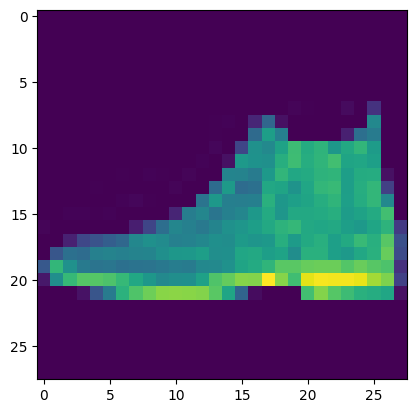

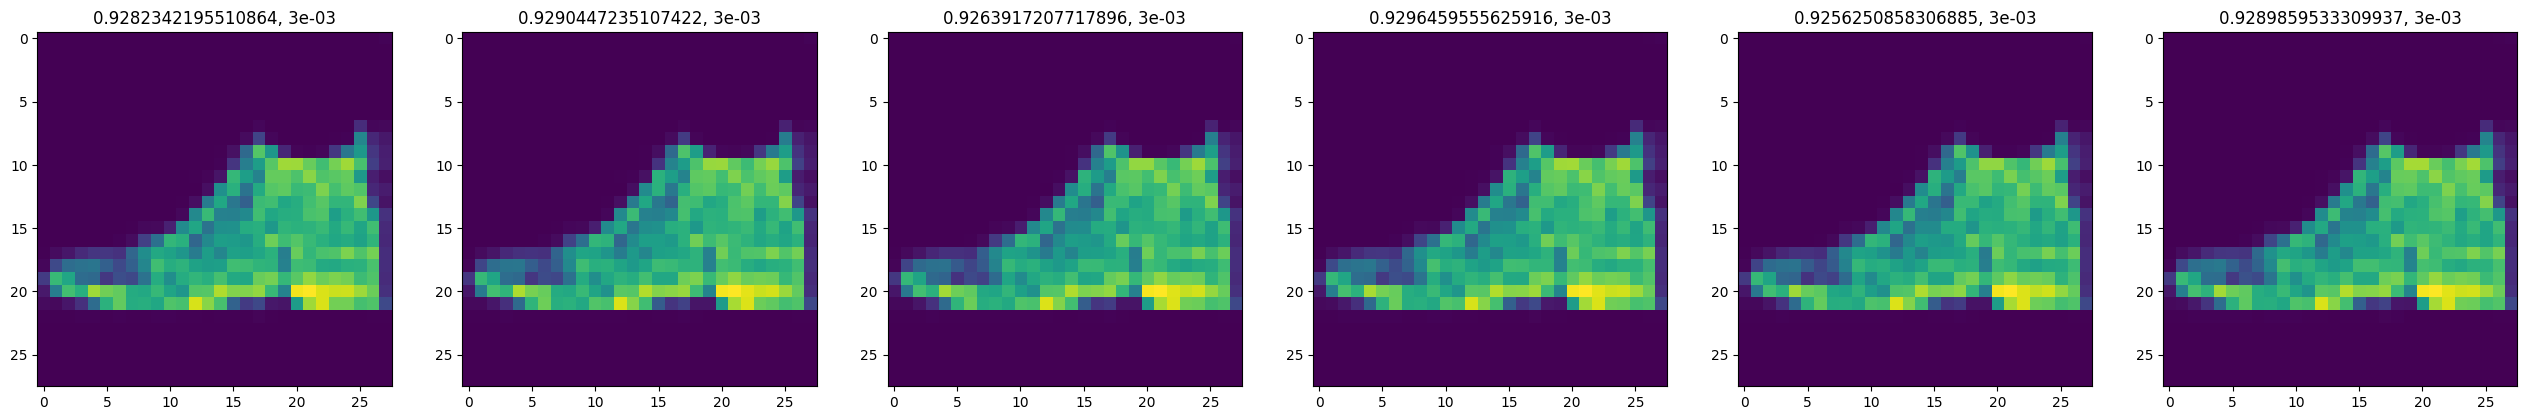

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 1000)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.9111861294242227
0.9120192288593122
0.9115981941769837
0.9120426303262164
0.911597937155681
0.9099958053060399


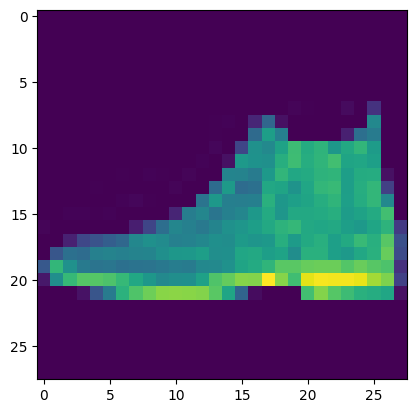

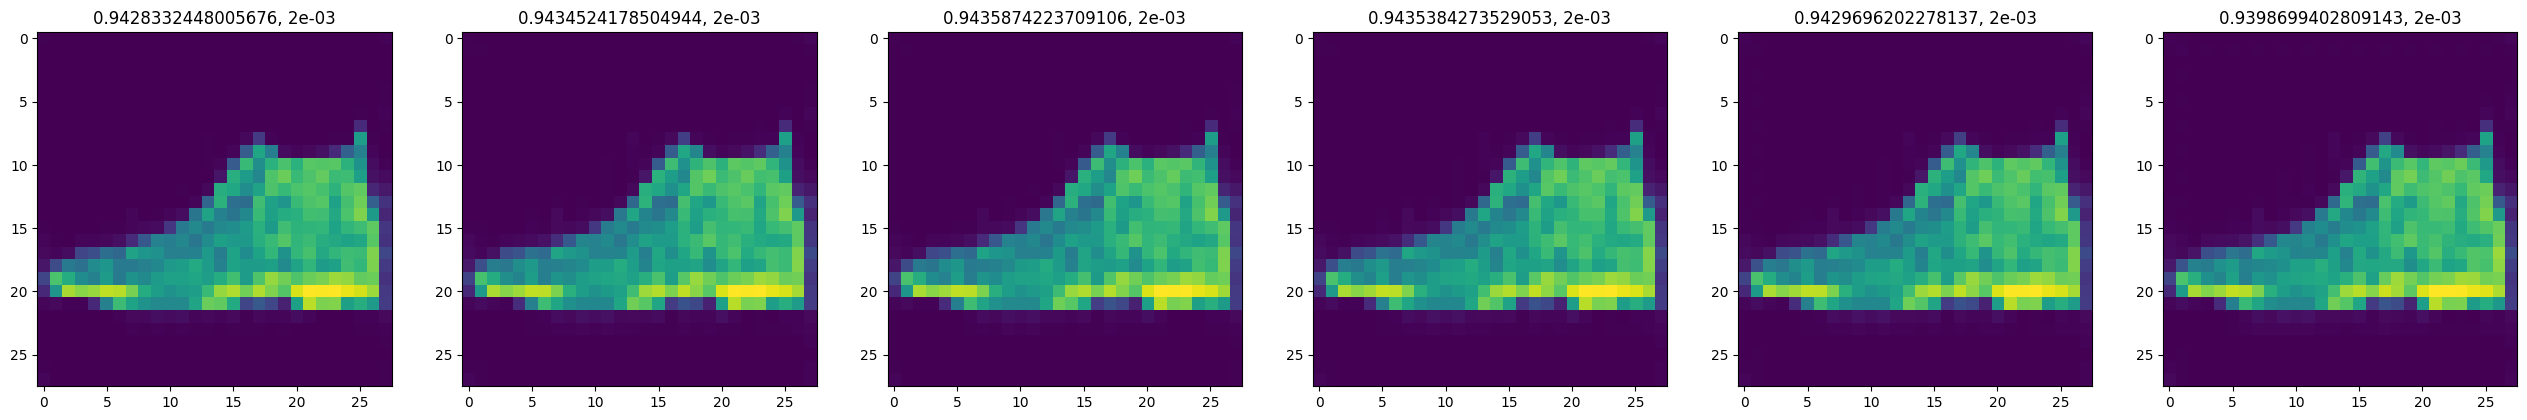

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 5000)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/157 [00:00<?, ?it/s]

0.8993166096650871
0.8991578980615944
0.9003653856599407
0.9008227002089191
0.8977424024016993
0.8972569935640712


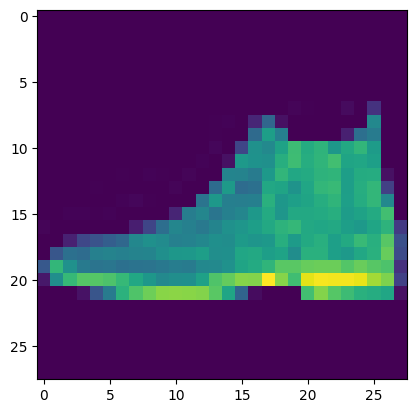

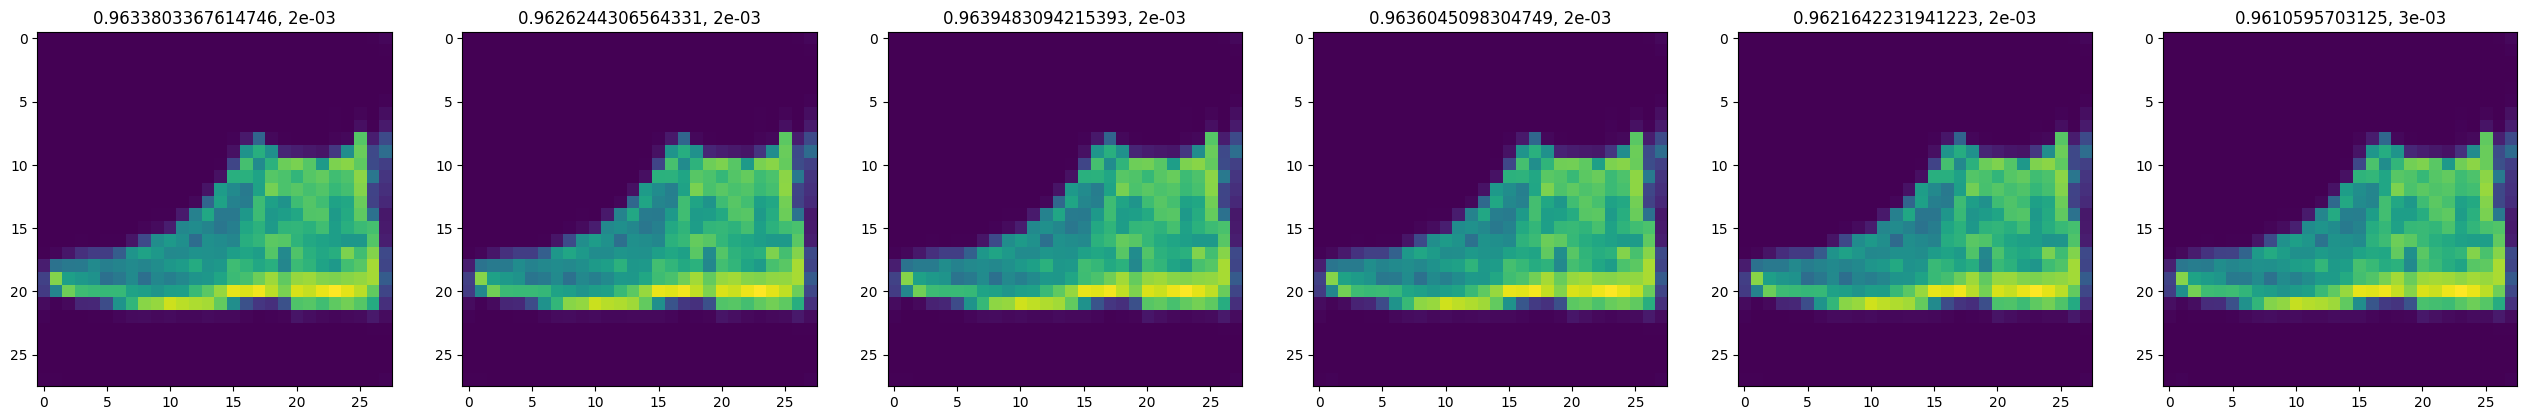

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7_ResSFL', 10000)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
reconstruct2([decoder for i in range(num_clients)])